In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from xgboost import XGBClassifier

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,fbeta_score
from sklearn.metrics import log_loss
from sklearn import metrics

from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC

from IPython.display import Image  
from six import StringIO  
import graphviz
import pydot 

## Data Pre-processing

In [3]:
ccdata = pd.read_csv('BankChurners.csv')
ccdata.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
#run once
ccdata.drop("CLIENTNUM",axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',axis=1,inplace=True)

In [5]:
#run once
ccdata['Gender'].replace({'M':1,'F':0},inplace=True)
ccdata["Attrition_Flag"].replace({'Existing Customer':0,'Attrited Customer':1},inplace=True)

In [6]:
ccdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  int64  
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [7]:
def objdata(dataset):
    for col in dataset:
        if dataset[col].dtypes=='object':
            print(f'{col}: {dataset[col].unique()}: {dataset[col].dtype} : count={dataset[col].count()}')
            
def othdata(dataset):
    for col in dataset:
        if dataset[col].dtypes!='object':
            print(f'{col}: {dataset[col].unique()}: {dataset[col].dtype} : count={dataset[col].count()}')

In [8]:
objdata(ccdata)

Education_Level: ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']: object : count=10127
Marital_Status: ['Married' 'Single' 'Unknown' 'Divorced']: object : count=10127
Income_Category: ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']: object : count=10127
Card_Category: ['Blue' 'Gold' 'Silver' 'Platinum']: object : count=10127


In [9]:
len(ccdata.loc[ccdata['Education_Level'] == 'Unknown'])            

1519

In [10]:
len(ccdata.loc[ccdata['Marital_Status'] == 'Unknown'])                

749

In [11]:
len(ccdata.loc[ccdata['Income_Category'] == 'Unknown'])            

1112

In [12]:
len(ccdata.loc[(ccdata['Education_Level'] == 'Unknown') | (ccdata['Marital_Status'] == 'Unknown') | (ccdata['Income_Category'] == 'Unknown')])            

3046

In [76]:
#XGBoost determines default behaviour for missing data, hence all we have to do is set the missing values to 0

In [16]:
##ccdata.drop(['Total_Trans_Amt','Avg_Utilization_Ratio',],axis=1,inplace=True)

In [13]:
#run once
#drop_first = True to avoid structural multicollinearity
ccdata2 = pd.get_dummies(data=ccdata,columns=['Education_Level','Marital_Status',"Income_Category",'Card_Category'],drop_first=True)
ccdata2.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Income_Category_Unknown',
       'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver'],
      dtype='object')

In [14]:
ccdata2.drop(['Avg_Open_To_Buy','Customer_Age','Total_Trans_Ct','Months_on_book','Total_Amt_Chng_Q4_Q1'],axis=1,inplace=True)

In [20]:
def xgboost_results(X_train,X_test,y_train,y_test):
    print('XGBoost Model Results\n')
    model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
    model.fit(X_train,y_train)
    xgbpreds = model.predict(X_test)
    print(classification_report(y_test,xgbpreds))
    print('Confusion Matrix\n',confusion_matrix(y_test,xgbpreds))
    plot_confusion_matrix(model,X_test,y_test,normalize='true',cmap='bwr')
    plt.show()
    print('Accuracy Score',round(accuracy_score(y_test,xgbpreds)*100,2),'%')
    print('Recall:',round(recall_score(y_test,xgbpreds)*100,2),'%')
    print('Precision:',round(precision_score(y_test,xgbpreds)*100,2),'%')
    print('F2 Score:',round(fbeta_score(y_test, xgbpreds, beta=2.0)*100,2),'%\n')
    print('The Training Accuracy is :',model.score(X_train,y_train))
    print('The Testing Accuracy is :', model.score(X_test,y_test))
    #running log loss on training data
    pred_proba = model.predict_proba(X_train)
    print('The log loss on training data is ',log_loss(y_train,pred_proba))
    #running log loss on testing data
    pred_proba_t = model.predict_proba(X_test)
    print('The log loss on testing data is ',log_loss(y_test,pred_proba_t),'\n')    
    df = pd.DataFrame({"Feature_names":X_train.columns,'Importances':model.feature_importances_})
    df1 = df.sort_values(by='Importances',ascending=False).reset_index()
    print(df1,'\n')
    df2 = df1[:19].sort_values(by='Importances',ascending=False)
    
    plt.figure(figsize=(8,8))
    #plt.barh(df2['Feature_names'],df2['Importances'])
    
    df2['cumsum'] =  df2['Importances'].cumsum(axis=0)
    df2 = df2.set_index("Feature_names")
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
    fig.suptitle("Features Importance", fontsize=15)
    ax[0].title.set_text('variables')
    df2[["Importances"]].sort_values(by="Importances").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
    ax[0].set(ylabel="")
    ax[1].title.set_text('cumulative')
    
    df2[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
    ax[1].set(xlabel="", xticks=np.arange(len(df2)), 
          xticklabels=df2.index)
    plt.xticks(rotation=70)
    plt.grid(axis='both')
    plt.show()
    plt.tight_layout()

In [16]:
X = ccdata2.drop("Attrition_Flag",axis=1)
y = ccdata2['Attrition_Flag']

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

## Hyperparameter Optimization

In [167]:
r_xgb = XGBClassifier(use_label_encoder=False)

In [168]:
from sklearn.model_selection import GridSearchCV

In [169]:
#round1
xgbparam_grid = [
    {
        'objective':['binary:logistic','binary:logitraw','binary:hinge','count:poisson'],
        'max_depth':np.arange(5,30,5),
        'learning_rate':[0.01,0.05,0.1],
        'gamma':[0.1,0.25,1],
        'reg_lambda':[0,1,10]
    }
]

#round2

In [170]:
clf = GridSearchCV(r_xgb, param_grid = xgbparam_grid, cv = 5, verbose=True, n_jobs = -1)

In [171]:
best_clf = clf.fit(X_train,y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[00:44:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [172]:
rawresults = pd.DataFrame(clf.cv_results_)
#rawresults

In [173]:
best_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [175]:
best_clf.best_score_

0.9428609679162856

## Preliminary Testing (Pre-feature selection)

XGBoost Model Results

[20:01:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2551
           1       0.89      0.82      0.85       488

    accuracy                           0.95      3039
   macro avg       0.93      0.90      0.91      3039
weighted avg       0.95      0.95      0.95      3039

Confusion Matrix
 [[2500   51]
 [  87  401]]


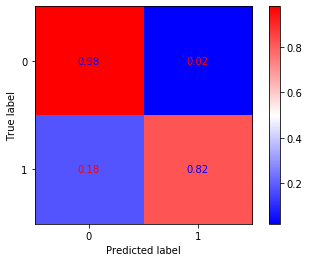

Accuracy Score 95.46 %
Recall: 82.17 %
Precision: 88.72 %
F2 Score: 83.4 %

The Training Accuracy is : 0.9840575620767494
The Testing Accuracy is : 0.9545903257650543
The log loss on training data is  0.06181233618606519
The log loss on testing data is  0.12438826527051638 

    index                   Feature_names  Importances
0       6             Total_Revolving_Bal     0.192796
1       2        Total_Relationship_Count     0.137705
2       7                 Total_Trans_Amt     0.115818
3       8             Total_Ct_Chng_Q4_Q1     0.074336
4       0                          Gender     0.055475
5       3          Months_Inactive_12_mon     0.043679
6       4           Contacts_Count_12_mon     0.034607
7       5                    Credit_Limit     0.032643
8       9           Avg_Utilization_Ratio     0.029307
9       1                 Dependent_count     0.024730
10     17           Marital_Status_Single     0.022681
11     16          Marital_Status_Married     0.020517
12     23

<Figure size 576x576 with 0 Axes>

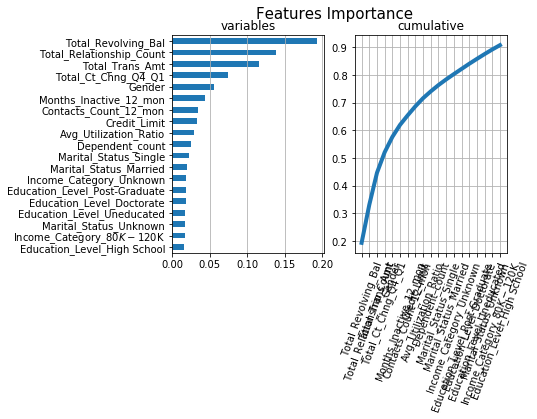

<Figure size 432x288 with 0 Axes>

In [21]:
#post-optimization results
xgboost_results(X_train,X_test,y_train,y_test)

In [ ]:
'Card_Category_Platinum','Card_Category_Gold','Card_Category_Silver','Income_Category_$40K - $60K','Education_Level_Unknown','Education_Level_Graduate'

In [22]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm, y_sm = smote.fit_resample(X_train,y_train)

y_sm.value_counts()
#generate train test split first then do resampling only on training set

1    5949
0    5949
Name: Attrition_Flag, dtype: int64

XGBoost Model Results

[20:01:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2551
           1       0.79      0.84      0.82       488

    accuracy                           0.94      3039
   macro avg       0.88      0.90      0.89      3039
weighted avg       0.94      0.94      0.94      3039

Confusion Matrix
 [[2443  108]
 [  78  410]]


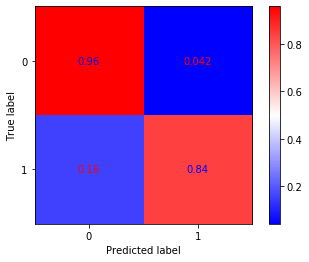

Accuracy Score 93.88 %
Recall: 84.02 %
Precision: 79.15 %
F2 Score: 83.0 %

The Training Accuracy is : 0.9917633215666498
The Testing Accuracy is : 0.9387956564659428
The log loss on training data is  0.04439492753456166
The log loss on testing data is  0.1497496095146661 

    index                   Feature_names  Importances
0       6             Total_Revolving_Bal     0.114634
1       7                 Total_Trans_Amt     0.107988
2       0                          Gender     0.087291
3       2        Total_Relationship_Count     0.071366
4      16          Marital_Status_Married     0.054303
5      17           Marital_Status_Single     0.052890
6      23         Income_Category_Unknown     0.045271
7      18          Marital_Status_Unknown     0.039482
8      19     Income_Category_$40K - $60K     0.039459
9       8             Total_Ct_Chng_Q4_Q1     0.037436
10     15         Education_Level_Unknown     0.035414
11     10       Education_Level_Doctorate     0.034704
12     11 

<Figure size 576x576 with 0 Axes>

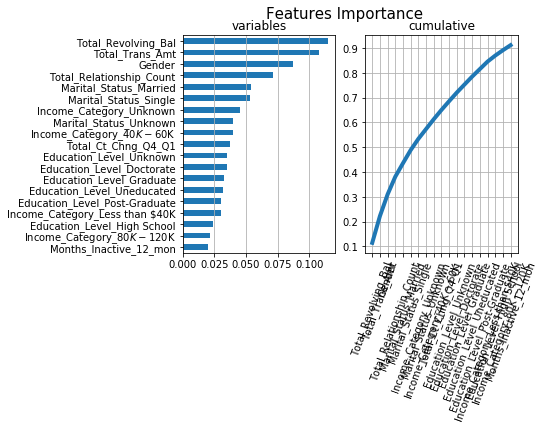

<Figure size 432x288 with 0 Axes>

In [23]:
xgboost_results(X_sm,X_test,y_sm,y_test)

In [24]:
##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train3, y_train3 = pipeline.fit_resample(X_train,y_train)
y_train3.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

XGBoost Model Results

[20:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2551
           1       0.78      0.88      0.83       488

    accuracy                           0.94      3039
   macro avg       0.88      0.92      0.89      3039
weighted avg       0.94      0.94      0.94      3039

Confusion Matrix
 [[2427  124]
 [  58  430]]


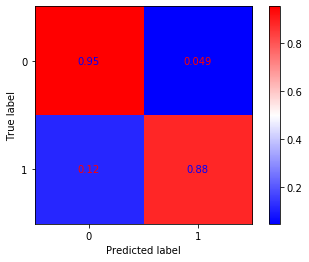

Accuracy Score 94.01 %
Recall: 88.11 %
Precision: 77.62 %
F2 Score: 85.79 %

The Training Accuracy is : 0.9918032786885246
The Testing Accuracy is : 0.9401118789075353
The log loss on training data is  0.061107215608184905
The log loss on testing data is  0.15179195764713455 

    index                   Feature_names  Importances
0       7                 Total_Trans_Amt     0.124965
1       2        Total_Relationship_Count     0.111903
2       6             Total_Revolving_Bal     0.096591
3       0                          Gender     0.078617
4       8             Total_Ct_Chng_Q4_Q1     0.058148
5      17           Marital_Status_Single     0.047444
6      11        Education_Level_Graduate     0.039693
7      16          Marital_Status_Married     0.036638
8      10       Education_Level_Doctorate     0.035717
9      18          Marital_Status_Unknown     0.033301
10     23         Income_Category_Unknown     0.030427
11      3          Months_Inactive_12_mon     0.027879
12     

<Figure size 576x576 with 0 Axes>

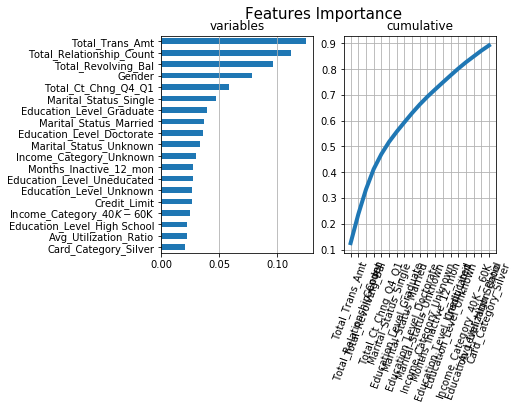

<Figure size 432x288 with 0 Axes>

In [25]:
xgboost_results(X_train3,X_test,y_train3,y_test)

## Post-feature selection

In [26]:
#feature selection
X_train2 = X_train.drop(['Card_Category_Platinum','Card_Category_Gold','Card_Category_Silver','Income_Category_$40K - $60K','Education_Level_Unknown'],axis=1)
X_test2 = X_test.drop(['Card_Category_Platinum','Card_Category_Gold','Card_Category_Silver','Income_Category_$40K - $60K','Education_Level_Unknown'],axis=1)

XGBoost Model Results

[20:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2551
           1       0.88      0.82      0.85       488

    accuracy                           0.95      3039
   macro avg       0.92      0.90      0.91      3039
weighted avg       0.95      0.95      0.95      3039

Confusion Matrix
 [[2498   53]
 [  88  400]]


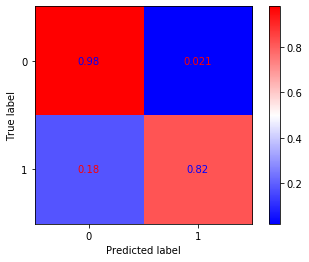

Accuracy Score 95.36 %
Recall: 81.97 %
Precision: 88.3 %
F2 Score: 83.16 %

The Training Accuracy is : 0.9829288939051919
The Testing Accuracy is : 0.9536031589338598
The log loss on training data is  0.06355734404935144
The log loss on testing data is  0.12286755721644517 

    index                   Feature_names  Importances
0       6             Total_Revolving_Bal     0.203424
1       2        Total_Relationship_Count     0.145108
2       7                 Total_Trans_Amt     0.121538
3       8             Total_Ct_Chng_Q4_Q1     0.083128
4       0                          Gender     0.055197
5       3          Months_Inactive_12_mon     0.045515
6       4           Contacts_Count_12_mon     0.034769
7       5                    Credit_Limit     0.033712
8       9           Avg_Utilization_Ratio     0.031957
9       1                 Dependent_count     0.025911
10     16           Marital_Status_Single     0.023831
11     21         Income_Category_Unknown     0.022556
12     15

<Figure size 576x576 with 0 Axes>

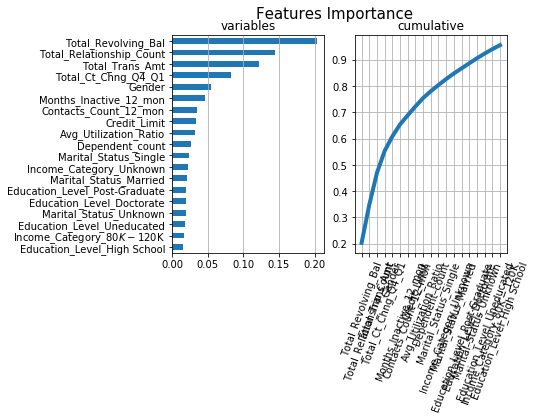

<Figure size 432x288 with 0 Axes>

In [27]:
#non-resampled results
xgboost_results(X_train2,X_test2,y_train,y_test)

In [28]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm2, y_sm2 = smote.fit_resample(X_train2,y_train)

y_sm2.value_counts()
#generate train test split first then do resampling only on training set

1    5949
0    5949
Name: Attrition_Flag, dtype: int64

XGBoost Model Results

[20:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2551
           1       0.78      0.84      0.81       488

    accuracy                           0.94      3039
   macro avg       0.87      0.90      0.89      3039
weighted avg       0.94      0.94      0.94      3039

Confusion Matrix
 [[2433  118]
 [  76  412]]


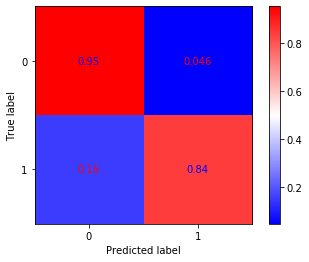

Accuracy Score 93.62 %
Recall: 84.43 %
Precision: 77.74 %
F2 Score: 83.0 %

The Training Accuracy is : 0.9915952260884182
The Testing Accuracy is : 0.9361632115827575
The log loss on training data is  0.04772872901106567
The log loss on testing data is  0.1533901790126238 

    index                   Feature_names  Importances
0       7                 Total_Trans_Amt     0.126320
1       6             Total_Revolving_Bal     0.119265
2       0                          Gender     0.106835
3       2        Total_Relationship_Count     0.093765
4      16           Marital_Status_Single     0.066436
5      15          Marital_Status_Married     0.062219
6      17          Marital_Status_Unknown     0.043990
7       8             Total_Ct_Chng_Q4_Q1     0.043587
8      11        Education_Level_Graduate     0.036718
9      21         Income_Category_Unknown     0.036624
10     20  Income_Category_Less than $40K     0.032871
11     14      Education_Level_Uneducated     0.030263
12     12 

<Figure size 576x576 with 0 Axes>

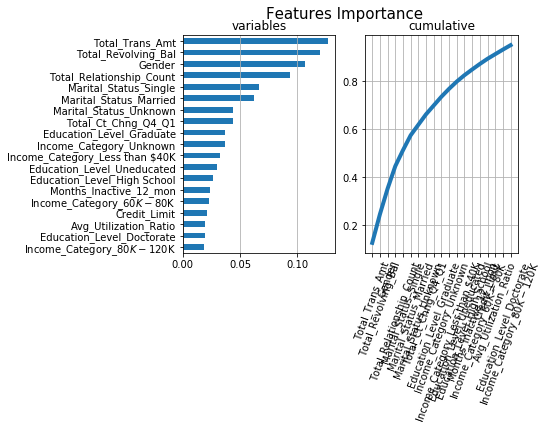

<Figure size 432x288 with 0 Axes>

In [29]:
xgboost_results(X_sm2,X_test2,y_sm2,y_test)

In [30]:
##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train4, y_train4 = pipeline.fit_resample(X_train2,y_train)
y_train4.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

XGBoost Model Results

[20:01:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2551
           1       0.75      0.89      0.81       488

    accuracy                           0.93      3039
   macro avg       0.86      0.91      0.89      3039
weighted avg       0.94      0.93      0.94      3039

Confusion Matrix
 [[2409  142]
 [  56  432]]


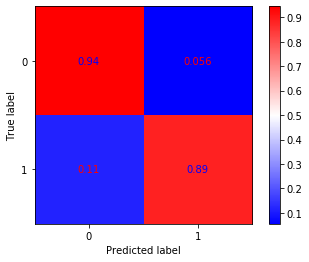

Accuracy Score 93.48 %
Recall: 88.52 %
Precision: 75.26 %
F2 Score: 85.51 %

The Training Accuracy is : 0.9889659520807061
The Testing Accuracy is : 0.9348469891411648
The log loss on training data is  0.06403915645462323
The log loss on testing data is  0.15992739130630992 

    index                   Feature_names  Importances
0       7                 Total_Trans_Amt     0.140220
1       6             Total_Revolving_Bal     0.123717
2       2        Total_Relationship_Count     0.122088
3       0                          Gender     0.076056
4       8             Total_Ct_Chng_Q4_Q1     0.060932
5      15          Marital_Status_Married     0.048862
6      16           Marital_Status_Single     0.045458
7      17          Marital_Status_Unknown     0.043470
8      11        Education_Level_Graduate     0.034536
9       3          Months_Inactive_12_mon     0.032261
10     14      Education_Level_Uneducated     0.029644
11      5                    Credit_Limit     0.029608
12     2

<Figure size 576x576 with 0 Axes>

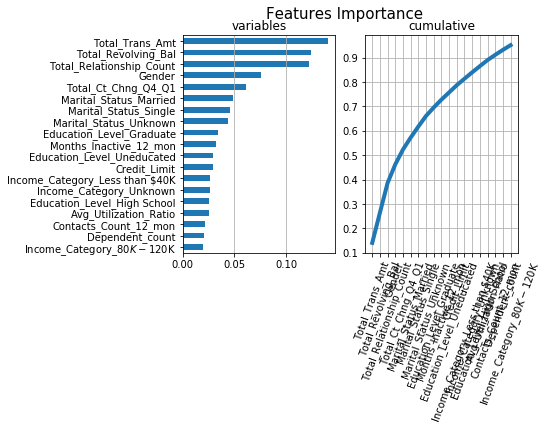

<Figure size 432x288 with 0 Axes>

In [31]:
xgboost_results(X_train4,X_test2,y_train4,y_test)

## Class weight rebalancing (Pre-feature selection)

In [32]:
def weighted_xgboost_results(X_train,X_test,y_train,y_test):
    print('XGBoost Model Results\n')
    neg_class = y_train.value_counts()[0]
    pos_class = y_train.value_counts()[1]
    sp_weight = neg_class/pos_class
    model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=sp_weight, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
    model.fit(X_train,y_train)
    xgbpreds = model.predict(X_test)
    print(classification_report(y_test,xgbpreds))
    print('Confusion Matrix\n',confusion_matrix(y_test,xgbpreds))
    plot_confusion_matrix(model,X_test,y_test,normalize='true',cmap='bwr')
    plt.show()
    print('Accuracy Score',round(accuracy_score(y_test,xgbpreds)*100,2),'%')
    print('Recall:',round(recall_score(y_test,xgbpreds)*100,2),'%')
    print('Precision:',round(precision_score(y_test,xgbpreds)*100,2),'%')
    print('F2 Score:',round(fbeta_score(y_test, xgbpreds, beta=2.0)*100,2),'%\n')
    print('The Training Accuracy is :',model.score(X_train,y_train))
    print('The Testing Accuracy is :', model.score(X_test,y_test))
    #running log loss on training data
    pred_proba = model.predict_proba(X_train)
    print('The log loss on training data is ',log_loss(y_train,pred_proba))
    #running log loss on testing data
    pred_proba_t = model.predict_proba(X_test)
    print('The log loss on testing data is ',log_loss(y_test,pred_proba_t),'\n')    
    df = pd.DataFrame({"Feature_names":X_train.columns,'Importances':model.feature_importances_})
    df1 = df.sort_values(by='Importances',ascending=False).reset_index()
    print(df1,'\n')
    df2 = df1[:19].sort_values(by='Importances',ascending=False)
    
    plt.figure(figsize=(8,8))
    #plt.barh(df2['Feature_names'],df2['Importances'])
    
    df2['cumsum'] =  df2['Importances'].cumsum(axis=0)
    df2 = df2.set_index("Feature_names")
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
    fig.suptitle("Features Importance", fontsize=15)
    ax[0].title.set_text('variables')
    df2[["Importances"]].sort_values(by="Importances").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
    ax[0].set(ylabel="")
    ax[1].title.set_text('cumulative')
    
    df2[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
    ax[1].set(xlabel="", xticks=np.arange(len(df2)), 
          xticklabels=df2.index)
    plt.xticks(rotation=70)
    plt.grid(axis='both')
    plt.show()
    plt.tight_layout()

XGBoost Model Results

[20:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2551
           1       0.79      0.89      0.84       488

    accuracy                           0.94      3039
   macro avg       0.88      0.92      0.90      3039
weighted avg       0.95      0.94      0.95      3039

Confusion Matrix
 [[2434  117]
 [  54  434]]


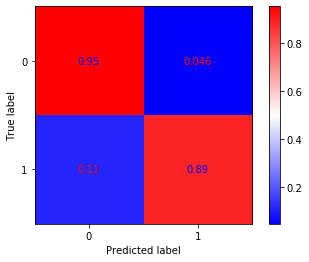

Accuracy Score 94.37 %
Recall: 88.93 %
Precision: 78.77 %
F2 Score: 86.7 %

The Training Accuracy is : 0.9865970654627539
The Testing Accuracy is : 0.9437314906219151
The log loss on training data is  0.05413450624303635
The log loss on testing data is  0.13867152991610254 

    index                   Feature_names  Importances
0       7                 Total_Trans_Amt     0.164071
1       6             Total_Revolving_Bal     0.142258
2      25          Card_Category_Platinum     0.110730
3       2        Total_Relationship_Count     0.082114
4       8             Total_Ct_Chng_Q4_Q1     0.056046
5       0                          Gender     0.039071
6       3          Months_Inactive_12_mon     0.034445
7       5                    Credit_Limit     0.030898
8       9           Avg_Utilization_Ratio     0.030235
9       4           Contacts_Count_12_mon     0.027777
10     17           Marital_Status_Single     0.022327
11      1                 Dependent_count     0.021039
12     22

<Figure size 576x576 with 0 Axes>

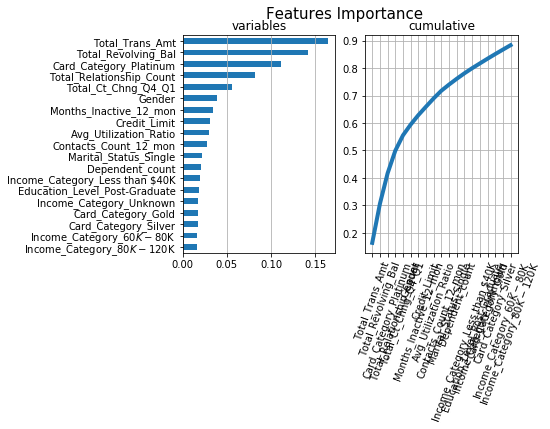

<Figure size 432x288 with 0 Axes>

In [33]:
weighted_xgboost_results(X_train,X_test,y_train,y_test)

XGBoost Model Results

[20:02:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2551
           1       0.79      0.84      0.82       488

    accuracy                           0.94      3039
   macro avg       0.88      0.90      0.89      3039
weighted avg       0.94      0.94      0.94      3039

Confusion Matrix
 [[2443  108]
 [  78  410]]


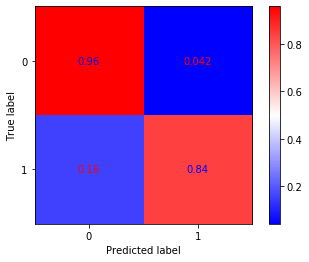

Accuracy Score 93.88 %
Recall: 84.02 %
Precision: 79.15 %
F2 Score: 83.0 %

The Training Accuracy is : 0.9917633215666498
The Testing Accuracy is : 0.9387956564659428
The log loss on training data is  0.04439492753456166
The log loss on testing data is  0.1497496095146661 

    index                   Feature_names  Importances
0       6             Total_Revolving_Bal     0.114634
1       7                 Total_Trans_Amt     0.107988
2       0                          Gender     0.087291
3       2        Total_Relationship_Count     0.071366
4      16          Marital_Status_Married     0.054303
5      17           Marital_Status_Single     0.052890
6      23         Income_Category_Unknown     0.045271
7      18          Marital_Status_Unknown     0.039482
8      19     Income_Category_$40K - $60K     0.039459
9       8             Total_Ct_Chng_Q4_Q1     0.037436
10     15         Education_Level_Unknown     0.035414
11     10       Education_Level_Doctorate     0.034704
12     11 

<Figure size 576x576 with 0 Axes>

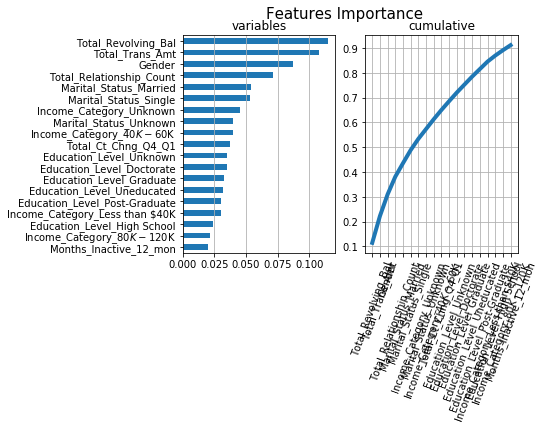

<Figure size 432x288 with 0 Axes>

In [34]:
weighted_xgboost_results(X_sm,X_test,y_sm,y_test)

XGBoost Model Results

[20:02:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2551
           1       0.73      0.90      0.81       488

    accuracy                           0.93      3039
   macro avg       0.85      0.92      0.88      3039
weighted avg       0.94      0.93      0.93      3039

Confusion Matrix
 [[2388  163]
 [  48  440]]


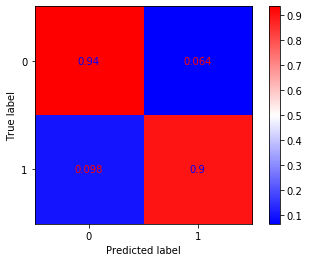

Accuracy Score 93.06 %
Recall: 90.16 %
Precision: 72.97 %
F2 Score: 86.11 %

The Training Accuracy is : 0.9906998738965952
The Testing Accuracy is : 0.9305692662059888
The log loss on training data is  0.05429254174541505
The log loss on testing data is  0.16650845275983595 

    index                   Feature_names  Importances
0       7                 Total_Trans_Amt     0.142974
1       6             Total_Revolving_Bal     0.096441
2       2        Total_Relationship_Count     0.093570
3       0                          Gender     0.064938
4       8             Total_Ct_Chng_Q4_Q1     0.057702
5      17           Marital_Status_Single     0.046023
6      11        Education_Level_Graduate     0.040799
7      16          Marital_Status_Married     0.036514
8      10       Education_Level_Doctorate     0.034773
9       5                    Credit_Limit     0.031214
10     18          Marital_Status_Unknown     0.030913
11      3          Months_Inactive_12_mon     0.028845
12     1

<Figure size 576x576 with 0 Axes>

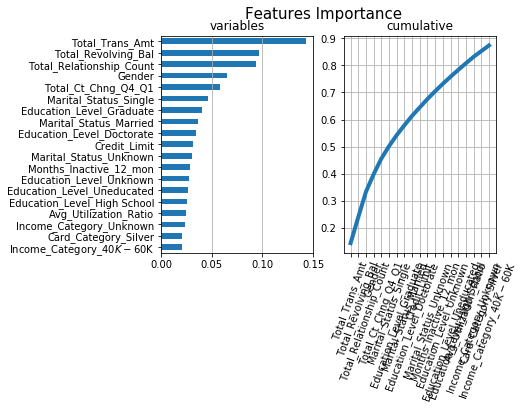

<Figure size 432x288 with 0 Axes>

In [35]:
weighted_xgboost_results(X_train3,X_test,y_train3,y_test)

## Class weight rebalancing (Post-feature selection)

XGBoost Model Results

[20:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2551
           1       0.78      0.89      0.83       488

    accuracy                           0.94      3039
   macro avg       0.88      0.92      0.90      3039
weighted avg       0.95      0.94      0.94      3039

Confusion Matrix
 [[2429  122]
 [  53  435]]


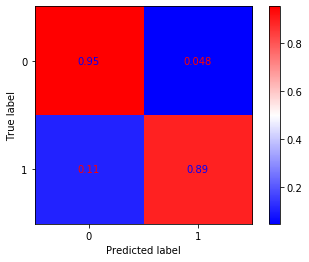

Accuracy Score 94.24 %
Recall: 89.14 %
Precision: 78.1 %
F2 Score: 86.69 %

The Training Accuracy is : 0.9861738148984198
The Testing Accuracy is : 0.9424152681803225
The log loss on training data is  0.05445771365428682
The log loss on testing data is  0.13628305829181522 

    index                   Feature_names  Importances
0       7                 Total_Trans_Amt     0.192846
1       6             Total_Revolving_Bal     0.175917
2       2        Total_Relationship_Count     0.097080
3       8             Total_Ct_Chng_Q4_Q1     0.067819
4       0                          Gender     0.048443
5       3          Months_Inactive_12_mon     0.041099
6       9           Avg_Utilization_Ratio     0.039553
7       5                    Credit_Limit     0.036856
8       4           Contacts_Count_12_mon     0.033705
9       1                 Dependent_count     0.026152
10     16           Marital_Status_Single     0.024842
11     13   Education_Level_Post-Graduate     0.024010
12     20

<Figure size 576x576 with 0 Axes>

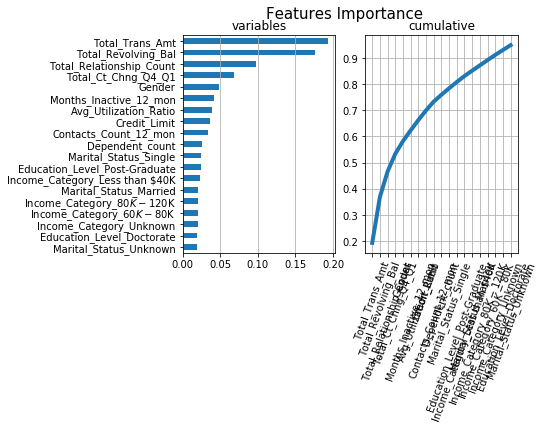

<Figure size 432x288 with 0 Axes>

In [36]:
weighted_xgboost_results(X_train2,X_test2,y_train,y_test)

XGBoost Model Results

[20:02:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2551
           1       0.78      0.84      0.81       488

    accuracy                           0.94      3039
   macro avg       0.87      0.90      0.89      3039
weighted avg       0.94      0.94      0.94      3039

Confusion Matrix
 [[2433  118]
 [  76  412]]


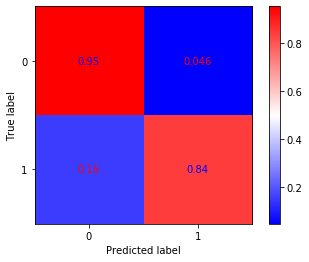

Accuracy Score 93.62 %
Recall: 84.43 %
Precision: 77.74 %
F2 Score: 83.0 %

The Training Accuracy is : 0.9915952260884182
The Testing Accuracy is : 0.9361632115827575
The log loss on training data is  0.04772872901106567
The log loss on testing data is  0.1533901790126238 

    index                   Feature_names  Importances
0       7                 Total_Trans_Amt     0.126320
1       6             Total_Revolving_Bal     0.119265
2       0                          Gender     0.106835
3       2        Total_Relationship_Count     0.093765
4      16           Marital_Status_Single     0.066436
5      15          Marital_Status_Married     0.062219
6      17          Marital_Status_Unknown     0.043990
7       8             Total_Ct_Chng_Q4_Q1     0.043587
8      11        Education_Level_Graduate     0.036718
9      21         Income_Category_Unknown     0.036624
10     20  Income_Category_Less than $40K     0.032871
11     14      Education_Level_Uneducated     0.030263
12     12 

<Figure size 576x576 with 0 Axes>

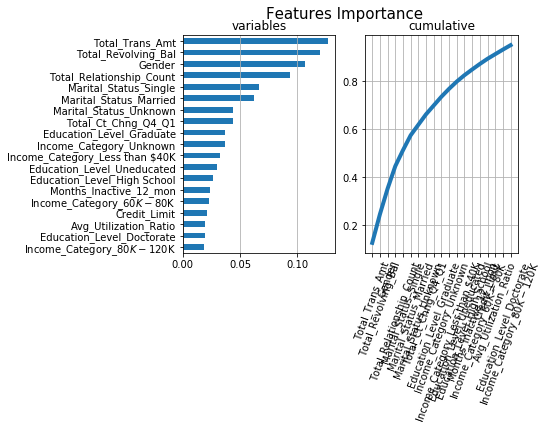

<Figure size 432x288 with 0 Axes>

In [37]:
weighted_xgboost_results(X_sm2,X_test2,y_sm2,y_test)

XGBoost Model Results

[20:02:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2551
           1       0.73      0.91      0.81       488

    accuracy                           0.93      3039
   macro avg       0.85      0.92      0.88      3039
weighted avg       0.94      0.93      0.93      3039

Confusion Matrix
 [[2384  167]
 [  45  443]]


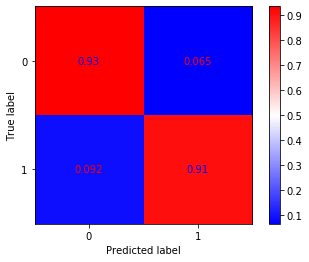

Accuracy Score 93.02 %
Recall: 90.78 %
Precision: 72.62 %
F2 Score: 86.46 %

The Training Accuracy is : 0.9897540983606558
The Testing Accuracy is : 0.9302402105955907
The log loss on training data is  0.05716958047550091
The log loss on testing data is  0.17155687631592528 

    index                   Feature_names  Importances
0       7                 Total_Trans_Amt     0.159488
1       2        Total_Relationship_Count     0.113211
2       6             Total_Revolving_Bal     0.105075
3       8             Total_Ct_Chng_Q4_Q1     0.063978
4       0                          Gender     0.061019
5      16           Marital_Status_Single     0.051435
6      15          Marital_Status_Married     0.048859
7      17          Marital_Status_Unknown     0.037919
8       3          Months_Inactive_12_mon     0.035230
9      11        Education_Level_Graduate     0.034920
10      5                    Credit_Limit     0.033706
11     14      Education_Level_Uneducated     0.031412
12      

<Figure size 576x576 with 0 Axes>

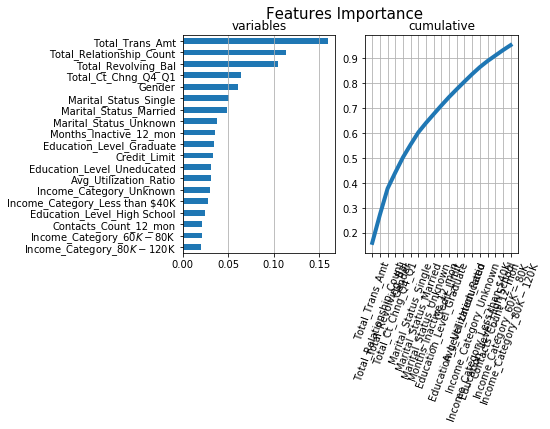

<Figure size 432x288 with 0 Axes>

In [38]:
weighted_xgboost_results(X_train4,X_test2,y_train4,y_test)